In [ ]:
from lxml import etree
import numpy as np
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import resize
import random
from time import time
from sklearn.decomposition import PCA
import pickle
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam
from keras import backend as K
from keras.models import Model

#pip3 install scikit-image==0.14.2 --user
#pip3 install numpy==1.16.3 --user
#https://stackoverflow.com/questions/54241226/importerror-cannot-import-name-validate-lengths  --comment of 'Alka'

Using TensorFlow backend.


In [ ]:
!wget -nc http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
!tar -xf VOCtrainval_11-May-2009.tar --totals

voc_root_folder = "/content/VOCdevkit/VOC2009"

--2020-05-23 00:36:55--  http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 935534080 (892M) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2009.tar’

VOCtrainval_11-May- 100%[===================>] 892.19M  77.3MB/s    in 12s     

2020-05-23 00:37:07 (76.4 MB/s) - ‘VOCtrainval_11-May-2009.tar’ saved [935534080/935534080]

Total bytes read: 935536640 (893MiB, 277MiB/s)


In [ ]:
# parameters that you should set before running this script
n_classes = 2
filter = ['cat', 'chair']      
voc_root_folder = "/content/VOCdevkit/"  
image_size = 128    # image size that you will use for your network (input images will be resampled to this size), lower if you have troubles on your laptop (hint: use io.imshow to inspect the quality of the resampled images before feeding it into your network!)
img_rows, img_cols = image_size, image_size
n_channels = 3

In [ ]:

# step1 - build list of filtered filenames
annotation_folder = os.path.join(voc_root_folder, "VOC2009/Annotations/")
annotation_files = os.listdir(annotation_folder)
filtered_filenames = []
for a_f in annotation_files:
    tree = etree.parse(os.path.join(annotation_folder, a_f))
    if np.any([tag.text == filt for tag in tree.iterfind(".//name") for filt in filter]):
        filtered_filenames.append(a_f[:-4])

# step2 - build (x,y) for TRAIN/VAL (classification)
classes_folder = os.path.join(voc_root_folder, "VOC2009/ImageSets/Main/")
classes_files = os.listdir(classes_folder)
train_files = [os.path.join(classes_folder, c_f) for filt in filter for c_f in classes_files if filt in c_f and '_train.txt' in c_f]
val_files = [os.path.join(classes_folder, c_f) for filt in filter for c_f in classes_files if filt in c_f and '_val.txt' in c_f]

In [ ]:
def build_classification_dataset(list_of_files):
    """ build training or validation set

    :param list_of_files: list of filenames to build trainset with
    :return: tuple with x np.ndarray of shape (n_images, image_size, image_size, 3) and  y np.ndarray of shape (n_images, n_classes)
    """
    temp = []
    train_labels = []
    for f_cf in list_of_files:
        with open(f_cf) as file:
            lines = file.read().splitlines()
            temp.append([line.split()[0] for line in lines if int(line.split()[-1]) == 1])
            label_id = [f_ind for f_ind, filt in enumerate(filter) if filt in f_cf][0]
            train_labels.append(len(temp[-1]) * [label_id])
    train_filter = [item for l in temp for item in l]

    image_folder = os.path.join(voc_root_folder, "VOC2009/JPEGImages/")
    image_filenames = [os.path.join(image_folder, file) for f in train_filter for file in os.listdir(image_folder) if
                       f in file]
    x = np.array([resize(io.imread(img_f), (image_size, image_size, 3)) for img_f in image_filenames]).astype(
        'float32')
    # changed y to an array of shape (num_examples, num_classes) with 0 if class is not present and 1 if class is present
    y_temp = []
    for tf in train_filter:
        y_temp.append([1 if tf in l else 0 for l in temp])
    y = np.array(y_temp)

    return x, y


x_train, y_train = build_classification_dataset(train_files)
print('%i training images from %i classes' %(x_train.shape[0], y_train.shape[1]))
x_val, y_val = build_classification_dataset(val_files)
print('%i validation images from %i classes' %(x_val.shape[0],  y_train.shape[1]))

# from here, you can start building your model
# you will only need x_train and x_val for the autoencoder
# you should extend the above script for the segmentation task (you will need a slightly different function for building the label images)

604 training images from 2 classes
607 validation images from 2 classes


### Display some random images

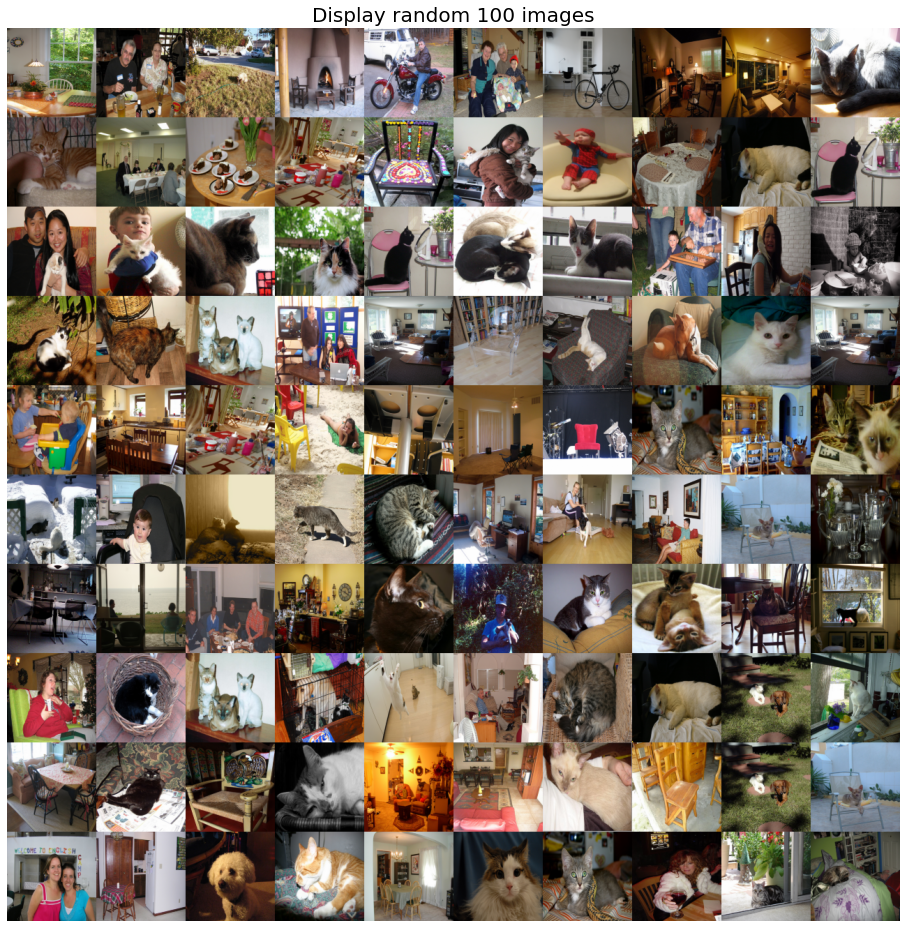

In [ ]:
num_test_images = 100
random_indices = [random.randint(0, x_train.shape[0]) for i in range(num_test_images)] 
vStack = []
for j in range(10):
    h_list = [x_train[random_indices[i+j*10]] for i in range(10)]
    h_tuple = tuple(h_list)
    vStack.append(np.hstack((h_tuple)))

image_list = [tuple(vStack[j]) for j in range(10)]
image = np.vstack((tuple(image_list)))

plt.figure(figsize=(16,50))
plt.title('Display random 100 images', fontsize=20)
plt.axis('off')
plt.imshow(image)

## Save the images in a dataframe for easier acces in the future

#### Keep the training set as it is
#### Split the validation set into two equal halves, one for validation and other for testing

In [ ]:
X_Train = x_train.copy()
X_Val = x_val.copy()
X_Train = (255*X_Train).astype('uint8')
X_Val = (255*X_Val).astype('uint8')

print('X_Train shape before reshaping = ' + str(X_Train.shape))
print('X_Val shape before reshaping = ' + str(X_Val.shape))
X_Train = X_Train.reshape(X_Train.shape[0],img_rows*img_cols*n_channels)
X_Val = X_Val.reshape(X_Val.shape[0],img_rows*img_cols*n_channels)
print('X_Train shape after reshaping = ' + str(X_Train.shape))
print('X_Val shape after reshaping = ' + str(X_Val.shape))

X_Train shape before reshaping = (604, 128, 128, 3)
X_Val shape before reshaping = (607, 128, 128, 3)
X_Train shape after reshaping = (604, 49152)
X_Val shape after reshaping = (607, 49152)


In [ ]:
#Save the reshaped images into pickel file
#Keep the training set as it is
X_T = X_Train.copy()
list_of_train_images = []
for i in range(len(X_T)):
    list_of_train_images.append(X_T[i])
print(len(list_of_train_images))  

list_of_train_classes = []
for i in range(len(y_train)):
    list_of_train_classes.append(y_train[i])
print(len(list_of_train_classes))  

X_Train_df = pd.DataFrame()
X_Train_df['Image_Array'] = list_of_train_images
X_Train_df['Class'] = list_of_train_classes

X_Train_df = X_Train_df.sample(frac=1).reset_index(drop=True)  #Reshuffle the images & it's respective class labels

X_Train_df.to_pickle('X_Train_'+str(n_classes)+'classes_'+str(img_rows)+'_'+str(img_cols)+'.pkl') #Save the file as pickle
print('Saved the training images into pickle')
print(X_Train_df.shape)
X_Train_df.head()

604
604
Saved the training images into pickle
(604, 2)


,Image_Array,Class
0,"[129, 112, 83, 130, 115, 85, 131, 117, 85, 132...","[0, 1]"
1,"[2, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 2, 1, 0, ...","[1, 0]"
2,"[143, 177, 97, 144, 176, 104, 141, 173, 98, 14...","[1, 0]"
3,"[114, 96, 4, 113, 89, 7, 105, 86, 11, 90, 91, ...","[1, 0]"
4,"[84, 55, 40, 90, 60, 42, 96, 65, 45, 102, 70, ...","[0, 1]"


In [ ]:
#Split the validation set into two equal halves, one for validation and other for testing
X_V = X_Val.copy()
list_of_val_images = []
for i in range(len(X_V)):
    list_of_val_images.append(X_V[i])
print(len(list_of_val_images))  

list_of_val_classes = []
for i in range(len(y_val)):
    list_of_val_classes.append(y_val[i])
print(len(list_of_val_classes))  

X_Val_df = pd.DataFrame()
X_Val_df['Image_Array'] = list_of_val_images
X_Val_df['Class'] = list_of_val_classes

print('Original shape of validation_df: ' + str(X_Val_df.shape))
X_Val_df = X_Val_df.sample(frac=1).reset_index(drop=True)  #Reshuffle the images & it's respective class labels
X_Test_df = X_Val_df[np.int(X_Val_df.shape[0]/2):]
X_Val_df = X_Val_df[:np.int(X_Val_df.shape[0]/2)]

X_Val_df.to_pickle('X_Val_'+str(n_classes)+'classes_'+str(img_rows)+'_'+str(img_cols)+'.pkl') #Save the file as pickle
print('Saved the validation images into pickle')
print(X_Val_df.shape)
X_Val_df.head()

607
607
Original shape of validation_df: (607, 2)
Saved the validation images into pickle
(303, 2)


,Image_Array,Class
0,"[220, 229, 245, 217, 227, 244, 215, 226, 243, ...","[1, 0]"
1,"[138, 119, 105, 139, 120, 106, 142, 121, 108, ...","[0, 1]"
2,"[59, 55, 52, 57, 56, 52, 59, 56, 53, 58, 55, 5...","[0, 1]"
3,"[122, 98, 89, 123, 100, 90, 125, 101, 91, 127,...","[1, 0]"
4,"[139, 95, 84, 140, 98, 88, 126, 80, 70, 139, 9...","[0, 1]"


In [ ]:
#Save also test image
X_Test_df.to_pickle('X_Test_'+str(n_classes)+'classes_'+str(img_rows)+'_'+str(img_cols)+'.pkl') #Save the file as pickle
print('Saved the test images into pickle')
print(X_Test_df.shape)
X_Test_df.head()

Saved the test images into pickle
(304, 2)


,Image_Array,Class
303,"[101, 101, 99, 103, 104, 103, 105, 107, 105, 1...","[0, 1]"
304,"[68, 83, 51, 80, 88, 53, 84, 85, 52, 88, 86, 6...","[0, 1]"
305,"[102, 86, 64, 106, 85, 69, 109, 88, 69, 111, 8...","[0, 1]"
306,"[131, 127, 93, 131, 127, 93, 131, 127, 92, 130...","[0, 1]"
307,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[1, 0]"


### Read the saved images

In [ ]:
train_df = pd.read_pickle('X_Train_2classes_128_128.pkl')
print('Training images')
x_train_array = np.array(train_df['Image_Array'].values.tolist())
x_train = x_train_array.reshape(x_train_array.shape[0],128,128,3)
print(x_train.shape)
y_train = np.array(train_df['Class'].values.tolist())
print('y',y_train.shape)

print(train_df.shape)
train_df.head()

Training images
(604, 128, 128, 3)
y (604, 2)
(604, 2)


,Image_Array,Class
0,"[129, 112, 83, 130, 115, 85, 131, 117, 85, 132...","[0, 1]"
1,"[2, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 2, 1, 0, ...","[1, 0]"
2,"[143, 177, 97, 144, 176, 104, 141, 173, 98, 14...","[1, 0]"
3,"[114, 96, 4, 113, 89, 7, 105, 86, 11, 90, 91, ...","[1, 0]"
4,"[84, 55, 40, 90, 60, 42, 96, 65, 45, 102, 70, ...","[0, 1]"


In [ ]:
val_df = pd.read_pickle('X_Val_2classes_128_128.pkl')
print('validation images')
x_val_array = np.array(val_df['Image_Array'].values.tolist())
x_val = x_val_array.reshape(x_val_array.shape[0],128,128,3)
print(x_val.shape)
y_val = np.array(val_df['Class'].values.tolist())
print(y_val.shape)

print(val_df.shape)
val_df.head()

validation images
(303, 128, 128, 3)
(303, 2)
(303, 2)


,Image_Array,Class
0,"[220, 229, 245, 217, 227, 244, 215, 226, 243, ...","[1, 0]"
1,"[138, 119, 105, 139, 120, 106, 142, 121, 108, ...","[0, 1]"
2,"[59, 55, 52, 57, 56, 52, 59, 56, 53, 58, 55, 5...","[0, 1]"
3,"[122, 98, 89, 123, 100, 90, 125, 101, 91, 127,...","[1, 0]"
4,"[139, 95, 84, 140, 98, 88, 126, 80, 70, 139, 9...","[0, 1]"


In [ ]:
test_df = pd.read_pickle('X_Test_2classes_128_128.pkl')
test_df.reset_index(drop=True,inplace=True)
print('testing images')
x_test_array = np.array(test_df['Image_Array'].values.tolist())
x_test = x_test_array.reshape(x_test_array.shape[0],128,128,3)
print(x_test.shape)
y_test = np.array(test_df['Class'].values.tolist())
print(y_test.shape)

print(test_df.shape)
test_df.head()

testing images
(304, 128, 128, 3)
(304, 2)
(304, 2)


,Image_Array,Class
0,"[101, 101, 99, 103, 104, 103, 105, 107, 105, 1...","[0, 1]"
1,"[68, 83, 51, 80, 88, 53, 84, 85, 52, 88, 86, 6...","[0, 1]"
2,"[102, 86, 64, 106, 85, 69, 109, 88, 69, 111, 8...","[0, 1]"
3,"[131, 127, 93, 131, 127, 93, 131, 127, 92, 130...","[0, 1]"
4,"[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[1, 0]"


# Object Classification

In [ ]:
#CONV Auto-encoder
#Takes time. Run on Google Colab.


input_img = Input(shape=(img_rows, img_cols, n_channels))
layer = Conv2D(64, (3, 3), padding='same')(input_img)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = MaxPooling2D((2, 2), padding='same')(layer)
layer = Conv2D(32, (3, 3), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = MaxPooling2D((2, 2), padding='same')(layer)
layer = Conv2D(16, (3, 3), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
encoded = MaxPooling2D((2, 2), padding='same', name='code')(layer)

layer = Conv2D(16, (3, 3), padding='same')(encoded)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = UpSampling2D((2, 2))(layer)
layer = Conv2D(32, (3, 3), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = UpSampling2D((2, 2))(layer)
layer = Conv2D(64, (3, 3), padding='same')(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = UpSampling2D((2, 2))(layer)
layer = Conv2D(3, (3, 3), padding='same')(layer)
layer = BatchNormalization()(layer)
decoded = Activation('sigmoid')(layer)
conv_autoencoder = Model(input_img, decoded)
conv_encoder = Model(conv_autoencoder.input,conv_autoencoder.layers[12].output)
print('Setting trainable to false')
for layer in conv_encoder.layers:
    layer.trainable = False  #Set the trainable to False
    
print(conv_encoder.summary())

#dropout = 0.2  #Not really used
adam = Adam(lr=0.00001)
n_epochs = 100
n_batches = 256

conv_en_output = conv_encoder.output
conv_en_output = Flatten()(conv_en_output)

predictions = Dense(n_classes, activation='sigmoid')(conv_en_output)

finetune_model = Model(inputs=conv_encoder.input, outputs=predictions)
print(finetune_model.summary())

finetune_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = finetune_model.fit(x_train, y_train, batch_size=n_batches,epochs=n_epochs,verbose=1,validation_data=(x_val, y_val),
shuffle=True)

# serialize model to JSON
model_json = finetune_model.to_json()
with open("finetune_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
finetune_model.save_weights("finetune_model.h5")
with open('finetune_model_history_dict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)



Setting trainable to false
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_22 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
activation_22 (Activation)   (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 32)        18464     
_________________________________________________________________
batch_normalization_23 (Batc (N

In [ ]:
# serialize model to JSON
model_json = finetune_model.to_json()
with open("finetune_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
finetune_model.save_weights("finetune_model.h5")
with open('finetune_model_history_dict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
# load json and create model
json_file = open('finetune_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
finetune_model = model_from_json(loaded_model_json)
# load weights into new model
finetune_model.load_weights("finetune_model.h5")
print("Loaded model from disk")
finetune_model.summary()

Loaded model from disk
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_22 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
activation_22 (Activation)   (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 32)        18464     
_________________________________________________________________
batch_normalization_23 (Batc (None,

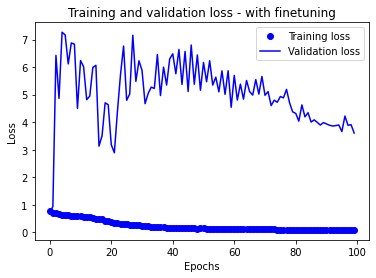

In [ ]:
history = pd.read_pickle('finetune_model_history_dict')
loss = history['loss']
val_loss = history['val_loss']
epochs = range(n_epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss - with finetuning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
rep=['cat','chair']

In [ ]:
y_predict_test = finetune_model.predict(x_train)

predicted_class: chair
Actual_class: chair


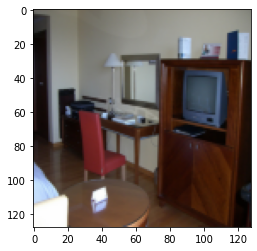

In [ ]:
plt.imshow(x_train[15], cmap='gray')


y =y_predict_test[15]
y1 = y_train[15]
name=rep[np.argmax(y)]
name1=rep[np.argmax(y1)]

print('predicted_class:',name)
print('Actual_class:',name1)




predicted_class: cat
Actual_class: cat


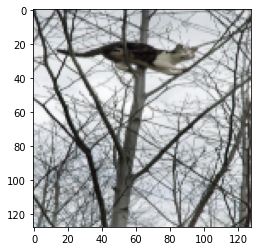

In [ ]:
plt.imshow(x_train[90], cmap='gray')


y =y_predict_test[90]
y1 = y_train[90]
name=rep[np.argmax(y)]
name1=rep[np.argmax(y1)]

print('predicted_class:',name)
print('Actual_class:',name1)


predicted_class: cat
Actual_class: chair


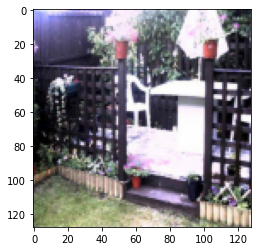

In [ ]:
plt.imshow(x_train[125], cmap='gray')


y =y_predict_test[125]
y1 = y_train[125]
name=rep[np.argmax(y)]
name1=rep[np.argmax(y1)]

print('predicted_class:',name)
print('Actual_class:',name1)

predicted_class: cat
Actual_class: chair


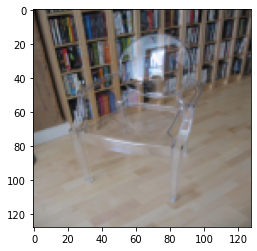

In [ ]:
plt.imshow(x_train[7], cmap='gray')


y =y_predict_test[7]
y1 = y_train[7]
name=rep[np.argmax(y)]
name1=rep[np.argmax(y1)]

print('predicted_class:',name)
print('Actual_class:',name1)

In [ ]:
y_train

array([[0, 1],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [0, 1],
       [0, 1]])

predicted_class: cat


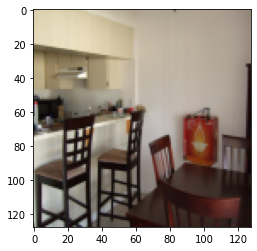

In [ ]:
plt.imshow(x_val[8,:,:], cmap='gray')
y_predict_test = finetune_model.predict(x_val)
y =y_predict_test[8]
name=rep[np.argmax(y)]
name=rep[np.argmax(y)]
name1=rep[np.argmax(y1)]

print('predicted_class:',name)


In [ ]:
y_val

array([[1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0,

predicted_class: chair
Actual_class: chair


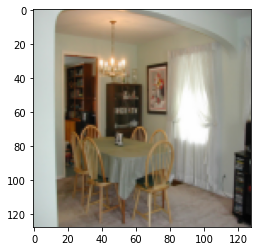

In [ ]:
plt.imshow(x_train[60,:,:], cmap='gray')
y_predict_test = finetune_model.predict(x_train)
y =y_predict_test[60]
name=rep[np.argmax(y)]

y1 = y_val[60]
name1=rep[np.argmax(y1)]

print('predicted_class:',name)
print('Actual_class:',name1)


predicted_class: chair
Actual_class: chair


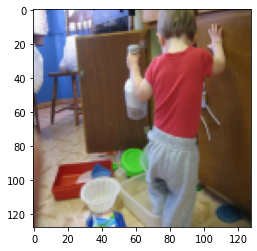

In [ ]:
plt.imshow(x_train[25,:,:], cmap='gray')
y_predict_test = finetune_model.predict(x_train)
y =y_predict_test[25]
name=rep[np.argmax(y)]
y1 = y_val[25]
name1=rep[np.argmax(y1)]

print('predicted_class:',name)
print('Actual_class:',name1)

predicted_class: cat
Actual_class: cat


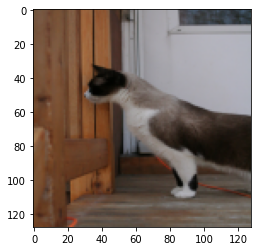

In [ ]:
plt.imshow(x_val[19,:,:], cmap='gray')
y =y_val[19]
name=rep[np.argmax(y)]
y1 = y_val[19]
name1=rep[np.argmax(y1)]

print('predicted_class:',name)
print('Actual_class:',name1)


In [ ]:
y_val

array([[1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [1, 0],
       [0, 1],
       [0,

# Adversial Attack -> Deep fool on autoencoder

In [ ]:
pip install adversarial-robustness-toolbox

In [ ]:
from art.config import ART_DATA_PATH
from art.classifiers import KerasClassifier
from art.attacks import ProjectedGradientDescent
from art.utils import get_file

from art.attacks import DeepFool
from art.classifiers import KerasClassifier
from art.utils import load_dataset

In [ ]:

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler()
formatter = logging.Formatter("[%(levelname)s] %(message)s")
handler.setFormatter(formatter)
logger.addHandler(handler)



In [ ]:
autoencoder = KerasClassifier(model=finetune_model, clip_values=(0, 2))

[WARNING] Keras model has no loss set. Classifier tries to use `k.sparse_categorical_crossentropy`.
[WARNING] Keras model has no loss set. Classifier tries to use `k.sparse_categorical_crossentropy`.
[WARNING] Keras model has no loss set. Classifier tries to use `k.sparse_categorical_crossentropy`.
[INFO] Inferred 13 hidden layers on Keras classifier.
[INFO] Inferred 13 hidden layers on Keras classifier.
[INFO] Inferred 13 hidden layers on Keras classifier.


In [ ]:
x_train_1=x_train.astype(float)
x_test_1=x_train.astype(float)

In [ ]:
logger.info("Create DeepFool attack")
adv_crafter = DeepFool(autoencoder)
logger.info("Craft attack on training examples")
x_train_adv = adv_crafter.generate(x_train_1)

logger.info("Craft attack test examples")
x_test_adv = adv_crafter.generate(x_test_1)

[INFO] Create DeepFool attack
[INFO] Create DeepFool attack
[INFO] Create DeepFool attack
[INFO] Craft attack on training examples
[INFO] Craft attack on training examples
[INFO] Craft attack on training examples
[INFO] Success rate of DeepFool attack: 60.10%
[INFO] Success rate of DeepFool attack: 60.10%
[INFO] Success rate of DeepFool attack: 60.10%
[INFO] Craft attack test examples
[INFO] Craft attack test examples
[INFO] Craft attack test examples
[INFO] Success rate of DeepFool attack: 60.76%
[INFO] Success rate of DeepFool attack: 60.76%
[INFO] Success rate of DeepFool attack: 60.76%


### fooled label

In [ ]:
y_predict_adv = finetune_model.predict(x_train_adv)

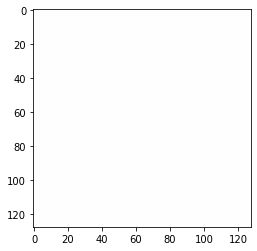

In [ ]:
x_train_adv1= 255 * x_train_adv # Now scale by 255
img = x_train_adv1.astype(np.uint8)
plt.imshow(img[0,:,:], cmap='gray')

predicted_class: bird
Actual_class: aeroplane


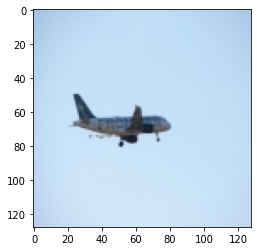

In [ ]:
plt.imshow(x_train[0,:,:], cmap='gray')
#y_predict_test = finetune_model.predict(x_train)
y =y_predict_adv[0]
name=rep[np.argmax(y)]
y1 = y_val[0]
name1=rep[np.argmax(y1)]

print('predicted_class:',name)
print('Actual_class:',name1)

### Actual Label

In [ ]:
y_predict= finetune_model.predict(x_train)

predicted_class: chair
Actual_class: cat


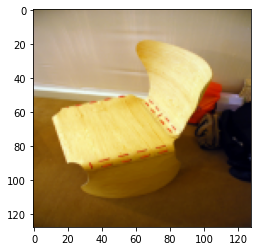

In [ ]:
plt.imshow(x_train[0,:,:], cmap='gray')
#y_predict_test = finetune_model.predict(x_train)
y =y_predict[0]
name=rep[np.argmax(y)]
y1 = y_val[0]
name1=rep[np.argmax(y1)]

print('predicted_class:',name)
print('Actual_class:',name1)

In [ ]:
from art.config import ART_DATA_PATH
from art.classifiers import KerasClassifier
from art.attacks import ProjectedGradientDescent
from art.utils import get_file

# Attack 2

In [ ]:

advattack = ProjectedGradientDescent(autoencoder, eps=8, eps_step=2, max_iter=10, targeted=False, 
                                  num_random_init=True)

[INFO] Success rate of attack: 0.00%
[INFO] Success rate of attack: 0.00%
[WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
[WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


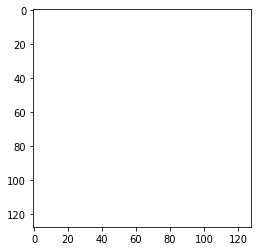

In [ ]:
n=5
X_train_adv = attack.generate(x_train_1[:n], y=y_train[:n])
plt.imshow(X_train_adv[0,:,:], cmap='gray')
